# Customer Segmentation Project

Goal
- Create customer segments using K-Means clustering.
- Demonstrate a full workflow: dataset creation, EDA, preprocessing, clustering, evaluation, visualization, and interpretation.

What you will learn
- How to generate a synthetic customer dataset
- How to explore and visualize customer data
- How to choose the number of clusters (Elbow + Silhouette)
- How to run K-Means, inspect clusters, and derive business insights


## 1. Requirements

Install required packages if you don't have them:

```python
pip install pandas numpy matplotlib seaborn scikit-learn
```

## 2. Imports + Reproducibility



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Styling
sns.set(style="whitegrid")

# Reproducible results
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**Explanation**: set a seed so results are reproducible. We will use pandas for data handling, seaborn/matplotlib for plots, scikit-learn for scaling and clustering.

## 3. Create Synthetic Dataset

In [2]:
# Create 3 clear customer segments + a small random set of outliers
n1 = 80   # group 1 - young, low income, high spending
n2 = 80   # group 2 - middle age, mid income, medium spending
n3 = 30   # group 3 - older, high income, low spending
n_noise = 10

# Group 1
age_1 = np.random.normal(loc=25, scale=4, size=n1).astype(int)
income_1 = np.random.normal(loc=30, scale=8, size=n1)  # in k$
spend_1 = np.random.normal(loc=75, scale=8, size=n1)   # spending score 0-100

# Group 2
age_2 = np.random.normal(loc=40, scale=6, size=n2).astype(int)
income_2 = np.random.normal(loc=60, scale=10, size=n2)
spend_2 = np.random.normal(loc=50, scale=10, size=n2)

# Group 3
age_3 = np.random.normal(loc=55, scale=5, size=n3).astype(int)
income_3 = np.random.normal(loc=110, scale=12, size=n3)
spend_3 = np.random.normal(loc=30, scale=7, size=n3)

# Noise / outliers
age_n = np.random.randint(18, 75, n_noise)
income_n = np.random.uniform(15, 180, n_noise)
spend_n = np.random.uniform(1, 100, n_noise)

# Combine
ages = np.concatenate([age_1, age_2, age_3, age_n])
incomes = np.concatenate([income_1, income_2, income_3, income_n])
spends = np.concatenate([spend_1, spend_2, spend_3, spend_n])

# Clip values to sensible ranges
ages = np.clip(ages, 18, 80)
incomes = np.clip(incomes, 5, 300)    # in thousands
spends = np.clip(spends, 1, 100)

# Build DataFrame
df = pd.DataFrame({
    'CustomerID': np.arange(1, len(ages)+1),
    'Age': ages,
    'Annual_Income_k$': np.round(incomes, 1),
    'Spending_Score': np.round(spends, 1),
})

# Shuffle rows to mix groups
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Show first rows
df.head()

,CustomerID,Age,Annual_Income_k$,Spending_Score
0,96,37,58.5,42.5
1,16,22,18.3,81.6
2,31,22,14.6,71.4
3,159,41,58.9,80.8
4,129,41,61.0,44.9


**Explanation:** we generate three clusters with distinct means so clustering will find meaningful groups. Income is in thousands for readability.


## 4. Save Dataset (optional) (Code)




In [3]:
df.to_csv('customer_data.csv', index=False)
print("Saved dataset to customer_data.csv")

Saved dataset to customer_data.csv


**Explanation**: saves the synthetic dataset so you can reuse it.

## 5. Quick Data Overview / EDA (Code + Explanation)


In [4]:
# Basic info
print("Shape:", df.shape)
display(df.head())

# Summary statistics
display(df.describe())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

Shape: (200, 4)


,CustomerID,Age,Annual_Income_k$,Spending_Score
0,96,37,58.5,42.5
1,16,22,18.3,81.6
2,31,22,14.6,71.4
3,159,41,58.9,80.8
4,129,41,61.0,44.9


,CustomerID,Age,Annual_Income_k$,Spending_Score
count,200.000000,200.00000,200.000000,200.000000
mean,100.500000,35.78500,56.634000,57.808500
std,57.879185,12.02463,29.533692,19.755302
min,1.000000,18.00000,14.600000,12.700000
25%,50.750000,25.00000,32.100000,41.725000
50%,100.500000,35.50000,52.350000,59.650000
75%,150.250000,44.25000,69.650000,75.175000
max,200.000000,72.00000,160.000000,100.000000


Missing values:
 CustomerID          0
Age                 0
Annual_Income_k$    0
Spending_Score      0
dtype: int64


**Explanation:** check shape, summary stats, and missing values. With synthetic data there are no missing values but this is a standard step.

## 6. Visual EDA - Distributions and Pairwise Relations (Code + Explanation)





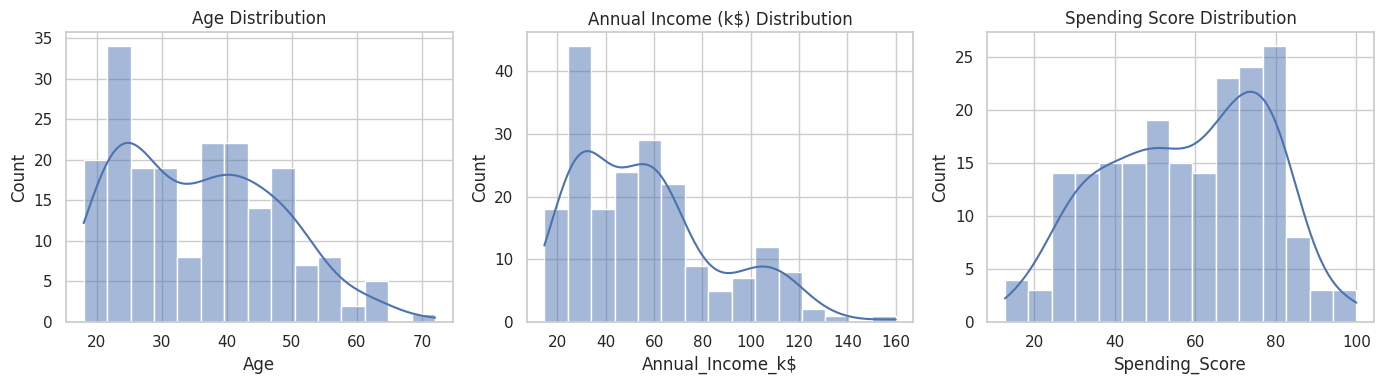

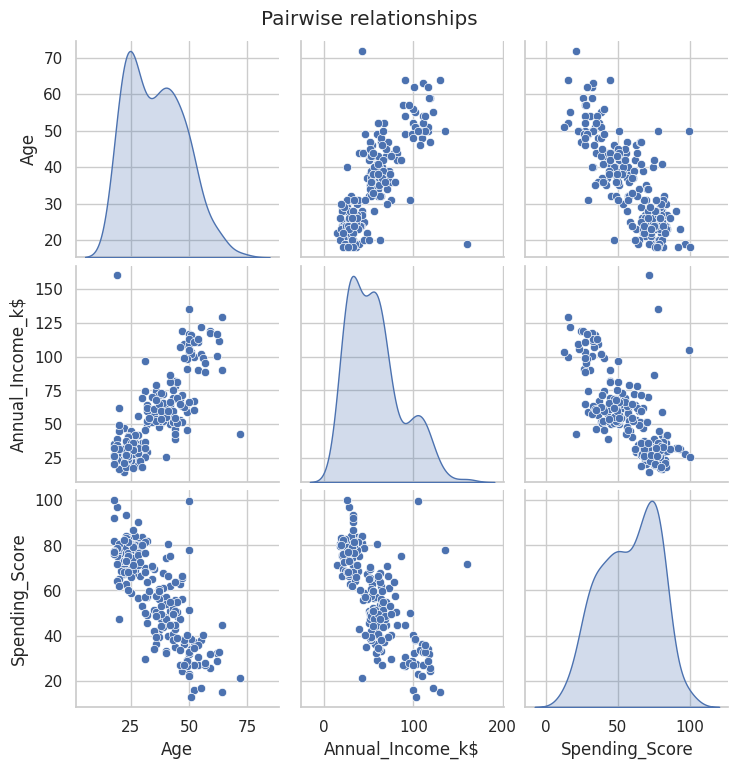

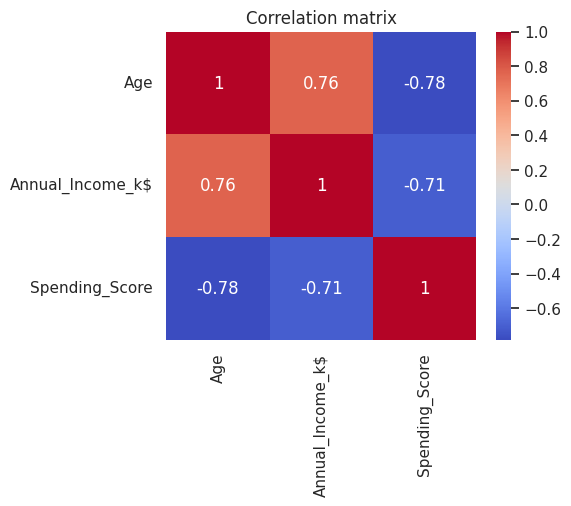

In [5]:
# Histograms
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(df['Age'], bins=15, kde=True)
plt.title('Age Distribution')

plt.subplot(1,3,2)
sns.histplot(df['Annual_Income_k$'], bins=15, kde=True)
plt.title('Annual Income (k$) Distribution')

plt.subplot(1,3,3)
sns.histplot(df['Spending_Score'], bins=15, kde=True)
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

# Pairplot to inspect relationships
sns.pairplot(df[['Age','Annual_Income_k$','Spending_Score']], diag_kind='kde', height=2.5)
plt.suptitle("Pairwise relationships", y=1.02)
plt.show()

# Correlation matrix
plt.figure(figsize=(5,4))
sns.heatmap(df[['Age','Annual_Income_k$','Spending_Score']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

**Explanation**: histograms show distributions; pairplot helps visualize clusters before modeling; correlation tells if variables are strongly linearly related (helps with feature selection).


## 7. Preprocessing - Feature Selection & Scaling (Code + Explanation)


In [6]:
# Choose features for clustering
features = df[['Age','Annual_Income_k$','Spending_Score']].copy()

# Standardize features (K-Means is distance-based)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Wrap scaled features back to DataFrame for convenience
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled_df.head()

,Age,Annual_Income_k$,Spending_Score
0,0.101296,0.063341,-0.776850
1,-1.149274,-1.301232,1.207332
2,-1.149274,-1.426827,0.689719
3,0.434781,0.076918,1.166735
4,0.434781,0.148202,-0.655059


**Explanation:** scaling puts features on the same scale (mean=0, std=1), preventing income (larger numeric range) from dominating distance measures.


## 8. Choosing number of clusters - Elbow method and Silhouette score (Code + Explanation)



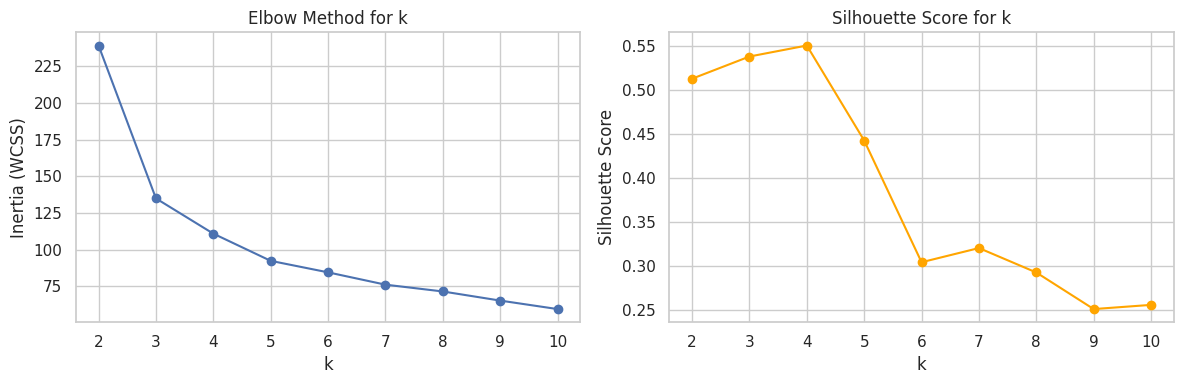

k=2, silhouette=0.513
k=3, silhouette=0.538
k=4, silhouette=0.550
k=5, silhouette=0.443
k=6, silhouette=0.304
k=7, silhouette=0.320
k=8, silhouette=0.293
k=9, silhouette=0.251
k=10, silhouette=0.256


In [7]:
inertia = []
sil_scores = []
K = range(2,11)  # try 2..10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(features_scaled, labels))

# Plot inertia (Elbow) and silhouette
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for k')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, '-o', color='orange')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for k')
plt.tight_layout()
plt.show()

# Print scores
for k, sil in zip(K, sil_scores):
    print(f"k={k}, silhouette={sil:.3f}")

**Explanation:**

- inertia (within-cluster sum of squares) decreases as k increases; look for the "elbow" where marginal improvement falls off.

- silhouette score measures how well-separated clusters are (range -1 to 1). Higher is better; use both methods together.

## 9. Fit final K-Means & attach cluster labels (Code + Explanation)

In [8]:
# Choose k (example: pick k with highest silhouette or elbow)
best_k = int(np.argmax(sil_scores) + 2)  # +2 because K starts at 2
print("Chosen k (by silhouette):", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(features_scaled)

# Examine cluster sizes
print(df['Cluster'].value_counts().sort_index())

Chosen k (by silhouette): 4
Cluster
0    32
1    83
2    82
3     3
Name: count, dtype: int64


**Explanation:** the code picks the k that maximizes silhouette. You may override it manually if elbow suggests a different value.


## 10. Inspect cluster centers (inverse transform to original scale) (Code + Explanation)



In [9]:
# Centers in scaled space
centers_scaled = kmeans_final.cluster_centers_

# Convert centers back to original feature scale
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=features.columns)
centers_df['Cluster'] = centers_df.index
centers_df

,Age,Annual_Income_k$,Spending_Score,Cluster
0,54.406250,104.712500,28.671875,0
1,39.638554,61.508434,50.280723,1
2,24.475610,30.130488,75.869512,2
3,39.666667,133.366667,83.200000,3


**Explanation:** shows the centroid values for each cluster in original units — these are useful to label segments (e.g., "High-income, low-spenders").

## 11. Cluster summary - descriptive statistics per cluster (Code + Explanation)




In [10]:
# Summary stats for each cluster
cluster_summary = df.groupby('Cluster').agg({
    'Age': ['mean','median','min','max'],
    'Annual_Income_k$': ['mean','median','min','max'],
    'Spending_Score': ['mean','median','min','max'],
    'CustomerID': 'count'
}).round(2)

# Clean column names
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary = cluster_summary.rename(columns={'CustomerID_count':'Count'})
cluster_summary

,Age_mean,Age_median,Age_min,Age_max,Annual_Income_k$_mean,Annual_Income_k$_median,Annual_Income_k$_min,Annual_Income_k$_max,Spending_Score_mean,Spending_Score_median,Spending_Score_min,Spending_Score_max,Count
Cluster,,,,,,,,,,,,,
0,54.41,53.0,46,72,104.71,106.25,42.5,129.5,28.67,28.15,12.7,44.5,32
1,39.64,40.0,20,52,61.51,60.80,38.8,96.7,50.28,49.90,27.0,80.8,83
2,24.48,24.0,18,40,30.13,30.50,14.6,51.8,75.87,76.30,58.8,100.0,82
3,39.67,50.0,19,50,133.37,135.50,104.6,160.0,83.20,78.10,71.7,99.8,3


**Explanation**: shows average age, income, spending for each cluster and cluster size, core for business interpretation.

## 12. Visualization of clusters (Code + Explanation)

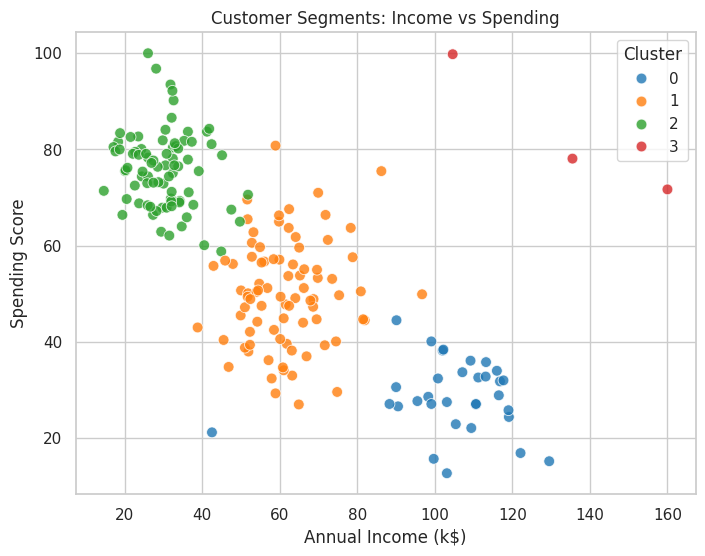

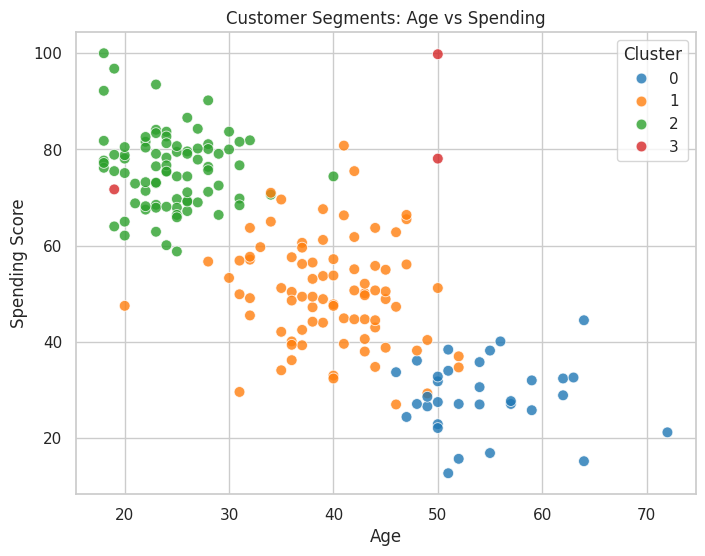

In [11]:
# Scatter: Income vs Spending (colored by cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Annual_Income_k$', y='Spending_Score',
    hue='Cluster', palette='tab10', data=df, s=60, alpha=0.8
)
plt.title('Customer Segments: Income vs Spending')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.legend(title='Cluster')
plt.show()

# Optional: Age vs Spending
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Age', y='Spending_Score',
    hue='Cluster', palette='tab10', data=df, s=60, alpha=0.8
)
plt.title('Customer Segments: Age vs Spending')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.show()

**Explanation:** scatter plots make segments visible and interpretable.

## 13. Save results (Code)




In [12]:
df.to_csv('customer_segments_labeled.csv', index=False)
print("Saved customer_segments_labeled.csv")

Saved customer_segments_labeled.csv


## 14. Interpretation & Business Insights

Interpretation template (fill based on cluster_summary and centers):

- Cluster 0: e.g., "Young, low-income, high-spending" — potential target for repeat purchase / loyalty program.
- Cluster 1: e.g., "Middle-age, mid-income, medium-spending" — potential up-sell opportunities.
- Cluster 2: e.g., "Older, high-income, low-spending" — they have high income but low spending score; consider targeted promotions.

Business actions
- Tailor marketing messages per segment (loyalty offers, premium bundles, retention campaigns).
- Test promotions on one segment and measure lift.
- Use clusters for personalized email campaigns and product recommendations.

Caveats
- Synthetic data; results on real data may differ.
- K-Means assumes spherical clusters and uses Euclidean distance; other algorithms (DBSCAN, hierarchical) might be more suitable in other cases.
- Always validate clusters against domain knowledge and business KPIs.


## 15. Next Steps & Extensions

- Add more features: Recency, Frequency, Monetary (RFM), channel usage, product preferences.
- Try dimensionality reduction (PCA) to visualize more features in 2D.
- Evaluate stability of clusters over time (re-run monthly).
- Deploy segmentation logic into a pipeline so new customers are assigned a cluster automatically.
- Experiment with different clustering algorithms (GaussianMixture, AgglomerativeClustering, DBSCAN).


## Extra: Full script version (single cell) - Paste/Run

       CustomerID        Age  Annual_Income_k$  Spending_Score
count  200.000000  200.00000        200.000000      200.000000
mean   100.500000   35.78500         56.634000       57.808500
std     57.879185   12.02463         29.533692       19.755302
min      1.000000   18.00000         14.600000       12.700000
25%     50.750000   25.00000         32.100000       41.725000
50%    100.500000   35.50000         52.350000       59.650000
75%    150.250000   44.25000         69.650000       75.175000
max    200.000000   72.00000        160.000000      100.000000
Best k by silhouette: 4
Cluster centers (original scale):
         Age  Annual_Income_k$  Spending_Score
0  54.406250        104.712500       28.671875
1  39.638554         61.508434       50.280723
2  24.475610         30.130488       75.869512
3  39.666667        133.366667       83.200000
Saved customer_segments_labeled.csv


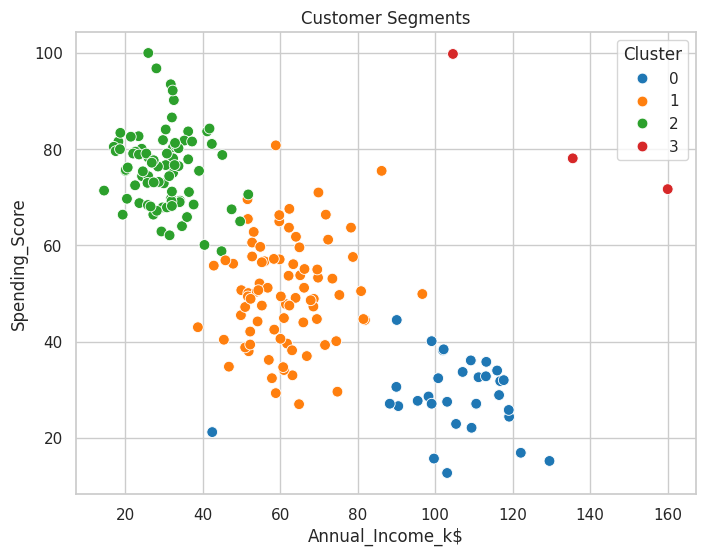

In [13]:
# Full runnable script (one cell) that generates data, clusters, and saves results.
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set(style='whitegrid')
np.random.seed(42)

# Generate synthetic customer data
n1, n2, n3, n_noise = 80, 80, 30, 10
age_1 = np.random.normal(25,4,n1).astype(int)
income_1 = np.random.normal(30,8,n1)
spend_1 = np.random.normal(75,8,n1)
age_2 = np.random.normal(40,6,n2).astype(int)
income_2 = np.random.normal(60,10,n2)
spend_2 = np.random.normal(50,10,n2)
age_3 = np.random.normal(55,5,n3).astype(int)
income_3 = np.random.normal(110,12,n3)
spend_3 = np.random.normal(30,7,n3)
age_n = np.random.randint(18,75,n_noise)
income_n = np.random.uniform(15,180,n_noise)
spend_n = np.random.uniform(1,100,n_noise)

ages = np.clip(np.concatenate([age_1,age_2,age_3,age_n]),18,80)
incomes = np.clip(np.concatenate([income_1,income_2,income_3,income_n]),5,300)
spends = np.clip(np.concatenate([spend_1,spend_2,spend_3,spend_n]),1,100)

df = pd.DataFrame({'CustomerID':np.arange(1,len(ages)+1),'Age':ages,
                   'Annual_Income_k$':np.round(incomes,1),'Spending_Score':np.round(spends,1)})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('customer_data.csv', index=False)

# EDA snippet
print(df.describe())

# Preprocess
features = df[['Age','Annual_Income_k$','Spending_Score']]
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Choose k using silhouette
sil_scores = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))
best_k = K[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)

# Fit final KMeans
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = km.fit_predict(X)

# Centers (inverse transform)
centers = scaler.inverse_transform(km.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features.columns)
print("Cluster centers (original scale):")
print(centers_df)

# Save
df.to_csv('customer_segments_labeled.csv', index=False)
print("Saved customer_segments_labeled.csv")

# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual_Income_k$', y='Spending_Score', hue='Cluster', data=df, palette='tab10', s=60)
plt.title('Customer Segments')
plt.show()